# Fake Image Detection 

## Importing Libraries

In [113]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#to generate same sequence of random numbers in whole file
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
#It is used during the training of a neural network to monitor a 
# specified metric (typically a validation metric) and stop training
#  early if certain criteria are met. The purpose of using EarlyStopping
#  is to prevent overfitting and to save time and resources when further
#  training is unlikely to improve the model's performance.
from keras.callbacks import EarlyStopping


PIL provides extensive capabilities for opening, manipulating, and saving many different image file formats.

to open image

ImageEnhance =>  can manipulate pixel colors in images, apply color mapping, and adjust brightness, contrast, and other color-related properties.

ImageChops => It provides various arithmetic and logical operations that you can perform on images.

In [114]:
from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance

## Making Dataset

## Convert to Error Level Analysis

In summary, this code takes an input image, compresses it, calculates the difference between the original and compressed versions, scales the difference image, and enhances its brightness. The resulting ELA image highlights areas where digital manipulation may have occurred by making the manipulated regions appear as brighter or darker areas compared to the rest of the image.

It generates ela_Image by enhancing brightness on the scale of pixel difference(difference between original and converted RGB image)

In [115]:
def convert_to_ela_image(path, quality):
    # creating a temporary filename for an intermediate image
    temp_filename = 'temp_file_name.jpg'
    # filename for ela image that will be generated
    ela_filename = 'temp_ela.png'
    
    # open image and convert to RGB
    image = Image.open(path).convert('RGB')

    # save image as jpg and keep quality as before
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    # calculate pixel difference between original image and RGB (new image) 
    # which will represents areas of image that have been altered.
    ela_image = ImageChops.difference(image, temp_image)
    
    # calculating minimum and maximum pixel values in the images
    extrema = ela_image.getextrema()

    # finds the maximum difference value among the extrema. This value is used to scale the ELA image.
    max_diff = max([ex[1] for ex in extrema])

    # ensuring max_diff is not zero to avoid division by zero.
    if max_diff == 0:
        max_diff = 1

    # calculates a scaling factor based on the maximum difference value. This factor
    # is used to stretch the ELA image's pixel values across the full 0-255 range.
    scale = 255.0 / max_diff
    
    # enhances the brightness of the ELA image by applying the previously calculated 
    # scaling factor for making the manipulated regions stand out more distinctly.
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


## Data preparation

### Read dataset and conversion to ELA

In [120]:
image_size = (128, 128)

this function converts the image into ela_image then resize it and flattens it to store in the 1D array as CNN requires data to be in 1D array 

In [121]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [122]:
X = []
Y = []

this function processes all the files present in Au and convert them:

first into ela_image and after resizing it, it flattens the layers of image and converts in 1D array

X stores all the flattened images and Y store the count of images

In [123]:
import random
path= "D:/major_project/dataset/real"
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        # if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
# X = X[:2100]
# Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
1000 1000


this function processes all the files present in Tp and convert them:

first into ela_image and after resizing it, it flattens the layers of image and converts in 1D array

X stores all the flattened images and Y store the count of images

now X stores all the images(Au + Tp)

In [124]:
path = "D:/major_project/dataset/fake"
#path = '/content/drive/MyDrive/Colab Notebooks/Image_Detector/CASIA2/Fake'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        # if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 1500 images
Processing 2000 images
2000 2000


In [125]:
# converting X into array 
X = np.array(X)
#used when you have a target variable (labels or classes) that is represented as integers and you want to convert it into a binary matrix format suitable for training machine learning models, especially neural networks.
# In Y there are two classes 1 for real and 0 for fake so to_categorical() converts this array into 2D array of labelled classes.
# this Y will look like [[1,0],[0,1]] for 0 and 1 label.
Y = to_categorical(Y, 2)
# # Reshape image data for a convolutional neural network
#  # Batch size, height, width, channels
X = X.reshape(-1, 128, 128, 3)

## CNN building

In [126]:
def build_model():
    #A sequential model is a linear stack of layers, where you can add layers one by one in a sequential fashion
    # Now we are building a model by adding layers of size same as image size.
    # These layers define the architecture of the neural network.
    model = Sequential()
    # adding two 2D layers having size as that of input image(training image)
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    # now we are adding maxPool layer which will create square region of 5x5 and retains the maximum value and discard other(just like KNN do to classify class)
    model.add(MaxPool2D(pool_size = (2, 2)))
    #  It is used to prevent overfitting and improve the generalization of the model during training. Dropout is a form of regularization that randomly deactivates a fraction of neurons or units in a neural network during each training batch
    # Add a Dropout layer with a dropout rate of 0.25 (25% of neurons deactivated during training)
    model.add(Dropout(0.25))
    # Add a Flatten layer to transition to fully connected layers (flattens output image coming from Convo2D, to give it as an input in dense interconnected layer)
    model.add(Flatten())
    # Add Input hidden layers with activation function
    model.add(Dense(256, activation = 'relu'))
    # Add a Dropout layer with a dropout rate of 0.5 (50% of neurons deactivated during training)
    model.add(Dropout(0.5))
    # Add Output layer with activation function
    model.add(Dense(2, activation = 'softmax'))
    return model

In [127]:
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 conv2d_7 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 60, 60, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 60, 60, 32)        0         
                                                                 
 flatten_3 (Flatten)         (None, 115200)            0         
                                                                 
 dense_6 (Dense)             (None, 256)               29491456  
                                                      

# Split into 8 : 2

Splitting the dataset into features (X) and target labels (Y)

Splitting the data into a training set (80%) and a testing set (20%)

In [128]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
# again converting 2D array to 1D array
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

1600 1600
400 400


### Model training

In [129]:
# epochs = 30
epochs = 1
batch_size = 32

from tensorflow.keras.optimizers import Adam

init_lr = 1e-4
optimizer = Adam(learning_rate=init_lr)

decay_steps=1000 specifies the number of steps (or training iterations) after which the learning rate will be updated.

decay_rate=0.9 sets the rate at which the learning rate will decay. In this case, it will decay by a factor of 0.9 after every decay_steps iterations.

This code sets up a learning rate schedule that starts at 0.01, decays by a factor of 0.9 every 1000 training steps, and uses this schedule to adjust the learning rate of an Adam optimizer during training. This combination of a learning rate schedule and optimizer is commonly used in deep learning to train neural networks effectively.

In [130]:
import tensorflow as tf

init_lr = 1e-4
decay_steps = 1000  # You can adjust this value based on your training schedule.
decay_rate = 0.9    # You can adjust this value based on your desired decay rate.

decay_lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=init_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
)

optimizer = tf.keras.optimizers.Adam(learning_rate=decay_lr)


The compile function in TensorFlow and Keras is used to configure the training process of a neural network model before training it on your dataset. When you compile a model, you specify various settings that control how the training will be performed. These settings include the optimization algorithm (optimizer), the loss function, and the evaluation metrics.

In [131]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

early stopping is used to stop the compilation of model after certain criteria meets.

In [132]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [133]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

50/50 [==============================] - 125s 2s/step - loss: 0.4951 - accuracy: 0.8044 - val_loss: 0.3257 - val_accuracy: 0.9075


In [134]:
# model.save('model_casia_run1.h5')

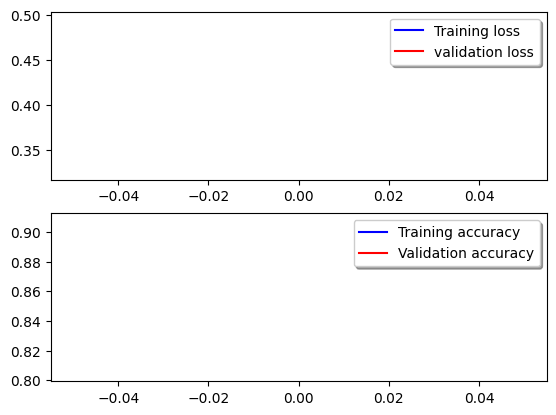

In [135]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [136]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score

# After training the model, you can use X_val and Y_val for evaluation
Y_pred_val = model.predict(X_val)

# Convert predictions classes to one hot vectors
Y_pred_classes_val = np.argmax(Y_pred_val, axis=1)
# Convert validation observations to one hot vectors
Y_true_val = np.argmax(Y_val, axis=1)

# Calculate overall accuracy on validation set
overall_accuracy_val = accuracy_score(Y_true_val, Y_pred_classes_val)
print(f'Overall Accuracy on Validation Set: {overall_accuracy_val * 100:.2f}%')

# Calculate other metrics using classification_report
report_val = classification_report(Y_true_val, Y_pred_classes_val, target_names=class_names)
print('Classification Report on Validation Set:')
print(report_val)

# Calculate confusion matrix on validation set
conf_matrix_val = confusion_matrix(Y_true_val, Y_pred_classes_val)
print('Confusion Matrix on Validation Set:')
print(conf_matrix_val)

true_positive = conf_matrix_val[1, 1]
false_positive = conf_matrix_val[0, 1]
false_negative = conf_matrix_val[1, 0]
true_negative = conf_matrix_val[0, 0]

# Calculate False Positive Rate (FPR) and False Negative Rate (FNR)
fpr = false_positive / (false_positive + true_negative)
fnr = false_negative / (false_negative + true_positive)

print(f'False Positive Rate (FPR): {fpr * 100:.2f}%')
print(f'False Negative Rate (FNR): {fnr * 100:.2f}%')

# Calculate Cohen's Kappa on validation set
cohen_kappa_val = cohen_kappa_score(Y_true_val, Y_pred_classes_val)
print(f'Cohen\'s Kappa on Validation Set: {cohen_kappa_val:.4f}')

13/13 [==============================] - 6s 471ms/step
Overall Accuracy on Validation Set: 90.75%
Classification Report on Validation Set:
              precision    recall  f1-score   support

        fake       0.93      0.87      0.90       189
        real       0.89      0.94      0.91       211

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400

Confusion Matrix on Validation Set:
[[164  25]
 [ 12 199]]
False Positive Rate (FPR): 13.23%
False Negative Rate (FNR): 5.69%
Cohen's Kappa on Validation Set: 0.8138


# 8 : 1

In [138]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.1, random_state=5)
# again converting 2D array to 1D array
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))




# epochs = 30
epochs = 1
batch_size = 32

from tensorflow.keras.optimizers import Adam

init_lr = 1e-4
optimizer = Adam(learning_rate=init_lr)



import tensorflow as tf

init_lr = 1e-4
decay_steps = 1000  # You can adjust this value based on your training schedule.
decay_rate = 0.9    # You can adjust this value based on your desired decay rate.

decay_lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=init_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
)

optimizer = tf.keras.optimizers.Adam(learning_rate=decay_lr)





model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])




early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')





hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])







fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)



from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score

# After training the model, you can use X_val and Y_val for evaluation
Y_pred_val = model.predict(X_val)

# Convert predictions classes to one hot vectors
Y_pred_classes_val = np.argmax(Y_pred_val, axis=1)
# Convert validation observations to one hot vectors
Y_true_val = np.argmax(Y_val, axis=1)

# Calculate overall accuracy on validation set
overall_accuracy_val = accuracy_score(Y_true_val, Y_pred_classes_val)
print(f'Overall Accuracy on Validation Set: {overall_accuracy_val * 100:.2f}%')

# Calculate other metrics using classification_report
report_val = classification_report(Y_true_val, Y_pred_classes_val, target_names=class_names)
print('Classification Report on Validation Set:')
print(report_val)

# Calculate confusion matrix on validation set
conf_matrix_val = confusion_matrix(Y_true_val, Y_pred_classes_val)
print('Confusion Matrix on Validation Set:')
print(conf_matrix_val)

true_positive = conf_matrix_val[1, 1]
false_positive = conf_matrix_val[0, 1]
false_negative = conf_matrix_val[1, 0]
true_negative = conf_matrix_val[0, 0]

# Calculate False Positive Rate (FPR) and False Negative Rate (FNR)
fpr = false_positive / (false_positive + true_negative)
fnr = false_negative / (false_negative + true_positive)

print(f'False Positive Rate (FPR): {fpr * 100:.2f}%')
print(f'False Negative Rate (FNR): {fnr * 100:.2f}%')

# Calculate Cohen's Kappa on validation set
cohen_kappa_val = cohen_kappa_score(Y_true_val, Y_pred_classes_val)
print(f'Cohen\'s Kappa on Validation Set: {cohen_kappa_val:.4f}')

ValueError: Found input variables with inconsistent numbers of samples: [98304000, 2000]

# 7 : 3

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.3, random_state=5)
# again converting 2D array to 1D array
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))




# epochs = 30
epochs = 1
batch_size = 32

from tensorflow.keras.optimizers import Adam

init_lr = 1e-4
optimizer = Adam(learning_rate=init_lr)



import tensorflow as tf

init_lr = 1e-4
decay_steps = 1000  # You can adjust this value based on your training schedule.
decay_rate = 0.9    # You can adjust this value based on your desired decay rate.

decay_lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=init_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
)

optimizer = tf.keras.optimizers.Adam(learning_rate=decay_lr)





model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])




early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')





hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])







fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)



from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score

# After training the model, you can use X_val and Y_val for evaluation
Y_pred_val = model.predict(X_val)

# Convert predictions classes to one hot vectors
Y_pred_classes_val = np.argmax(Y_pred_val, axis=1)
# Convert validation observations to one hot vectors
Y_true_val = np.argmax(Y_val, axis=1)

# Calculate overall accuracy on validation set
overall_accuracy_val = accuracy_score(Y_true_val, Y_pred_classes_val)
print(f'Overall Accuracy on Validation Set: {overall_accuracy_val * 100:.2f}%')

# Calculate other metrics using classification_report
report_val = classification_report(Y_true_val, Y_pred_classes_val, target_names=class_names)
print('Classification Report on Validation Set:')
print(report_val)

# Calculate confusion matrix on validation set
conf_matrix_val = confusion_matrix(Y_true_val, Y_pred_classes_val)
print('Confusion Matrix on Validation Set:')
print(conf_matrix_val)

true_positive = conf_matrix_val[1, 1]
false_positive = conf_matrix_val[0, 1]
false_negative = conf_matrix_val[1, 0]
true_negative = conf_matrix_val[0, 0]

# Calculate False Positive Rate (FPR) and False Negative Rate (FNR)
fpr = false_positive / (false_positive + true_negative)
fnr = false_negative / (false_negative + true_positive)

print(f'False Positive Rate (FPR): {fpr * 100:.2f}%')
print(f'False Negative Rate (FNR): {fnr * 100:.2f}%')

# Calculate Cohen's Kappa on validation set
cohen_kappa_val = cohen_kappa_score(Y_true_val, Y_pred_classes_val)
print(f'Cohen\'s Kappa on Validation Set: {cohen_kappa_val:.4f}')